In [28]:
# Import imports XD
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [2]:
# Import data
train = pd.read_csv( 'train.csv' , index_col= 'id' )

test = pd.read_csv( 'test.csv' , index_col = 'id' )

In [13]:
# Cleanup and wrangle data
train.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                          'percent_atom_al' : 'al_atom_p' ,
                          'percent_atom_ga' : 'ga_atom_p' , 
                          'percent_atom_in' : 'in_atom_p' , 
                          'lattice_vector_1_ang' : 'ang_1' ,
                          'lattice_vector_2_ang' : 'ang_2' , 
                          'lattice_vector_3_ang' : 'and_3' ,
                          'lattice_angle_alpha_degree' : 'angle_a' , 
                          'lattice_angle_beta_degree' : 'angle_b' ,
                          'lattice_angle_gamma_degree' : 'angle_g' ,
                          'formation_energy_ev_natom' : 'f_energy' ,
                          'bandgap_energy_ev' : 'bg_energy' } , inplace = True )

test.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                         'percent_atom_al' : 'al_atom_p' ,
                         'percent_atom_ga' : 'ga_atom_p' , 
                         'percent_atom_in' : 'in_atom_p' , 
                         'lattice_vector_1_ang' : 'ang_1' ,
                         'lattice_vector_2_ang' : 'ang_2' , 
                         'lattice_vector_3_ang' : 'and_3' ,
                         'lattice_angle_alpha_degree' : 'angle_a' , 
                         'lattice_angle_beta_degree' : 'angle_b' ,
                         'lattice_angle_gamma_degree' : 'angle_g' } , inplace = True )

def wrangle(df):

    atoms = [ 'al' , 'ga' , 'in' ]
    
    for elem in atoms:
        df[ f'{ elem }_atoms' ] = df.tot_atom * df[ f'{ elem }_atom_p' ]
    
    df[ 'al_ga_ratio' ] = df.al_atoms / df.ga_atoms
    df[ 'al_in_ratio' ] = df.al_atoms / df.in_atoms
    df[ 'in_ga_ratio' ] = df.in_atoms / df.ga_atoms
    
    redundant = [ 'al_atom_p' , 'ga_atom_p' , 'in_atom_p' ]
    
    for col in redundant:
        df.drop( columns = col , inplace = True )
    
    ratios = [ 'al_ga_ratio' , 'al_in_ratio' , 'in_ga_ratio' ]

    for col in ratios:
        df[ col ] = df[ col ].replace( np.inf , np.nan )
        df[ col ] = df[ col ].replace( np.nan , df[ col ].max() )
    
    return df

train = wrangle( train )

test = wrangle( test )

In [14]:
# Define X and y(target)
target1 = 'bg_energy'
target2 = 'f_energy'

X = train.drop( columns = [ target1 , target2 ] )
X_test = test

y1 = train[ target1 ]
y2 = train[ target2 ]

In [15]:
# Split data
X1_train, X1_val, y1_train, y1_val = train_test_split( 
    X , y1 , train_size = 0.9 , random_state = 19 )

X2_train, X2_val, y2_train, y2_val = train_test_split( 
    X , y2 , train_size = 0.9 , random_state = 19 )

y1_pred = [y1_train.mean()] * len(y1_train)
y2_pred = [y2_train.mean()] * len(y2_train)

def baselines():
    print('Band Gap Energy')
    print('Mean (eV): ', y1_train.mean())
    print('Baseline MAE: ' , mean_absolute_error( y1_train , y1_pred ) )
    print()
    print('Formation Energy')
    print('Mean (eV): ', y2_train.mean())
    print('Baseline MAE: ' , mean_absolute_error( y2_train , y2_pred ) )

baselines()

Band Gap Energy
Mean (eV):  2.0804772685185187
Baseline MAE:  0.8267515736025377

Formation Energy
Mean (eV):  0.18696375
Baseline MAE:  0.08535369444444445


In [16]:
# Define models and encoders    
ss = StandardScaler()

lr = LinearRegression()
r = Ridge( random_state = 19 )
rfr = RandomForestRegressor( random_state = 19 )
xgbr = XGBRegressor( random_state = 19 )
    
# Define models    
model_lr = make_pipeline( ss , lr )    
model_r = make_pipeline( r )
model_rfr = make_pipeline( rfr )
model_xgbr = make_pipeline( xgbr )

# Fit models to each target separately 
model_lr1 = model_lr.fit( X1_train , y1_train );    
model_r1 = model_r.fit( X1_train , y1_train );
model_rfr1 = model_rfr.fit( X1_train , y1_train );
model_xgbr1 = model_xgbr.fit( X1_train , y1_train );

model_lr2 = model_lr.fit( X2_train , y2_train );
model_r2 = model_r.fit( X2_train , y2_train );
model_rfr2 = model_rfr.fit( X2_train , y2_train );
model_xgbr2 = model_xgbr.fit( X2_train , y2_train );

In [17]:
# Mean absolute error values for models
def mae_scores():
    print('Linear Regression')
    print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_lr1.predict( X1_train ) ) , 3 ) )
    print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_lr1.predict( X1_val ) ) , 3 ) )
    print()
    print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_lr2.predict( X2_train ) ) , 3 ) )
    print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_lr2.predict( X2_val ) ) , 3 ) )
    print()

    print('Ridge Regression')
    print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_r1.predict( X1_train ) ) , 3 ) )
    print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_r1.predict( X1_val ) ) , 3 ) )
    print()
    print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_r2.predict( X2_train ) ) , 3 ) )
    print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_r2.predict( X2_val ) ) , 3 ) )
    print()
    
    print('Random Forest Regressor')
    print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_rfr1.predict( X1_train ) ) , 3 ) )
    print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_rfr1.predict( X1_val ) ) , 3 ) )
    print()
    print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_rfr2.predict( X2_train ) ) , 3 ) )
    print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_rfr2.predict( X2_val ) ) , 3 ) )
    print()

    print('XGBRegressor')
    print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_xgbr1.predict( X1_train ) ) , 3 ) )
    print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_xgbr1.predict( X1_val ) ) , 3 ) )
    print()
    print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_xgbr2.predict( X2_train ) ) , 3 ) )
    print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_xgbr2.predict( X2_val ) ) , 3 ) )
    
mae_scores()

Linear Regression
BandGap train MAE:  1.895
BandGap val MAE:  1.856

Formaion train MAE:  0.051
Formation val MAE:  0.054

Ridge Regression
BandGap train MAE:  1.895
BandGap val MAE:  1.856

Formaion train MAE:  0.051
Formation val MAE:  0.053

Random Forest Regressor
BandGap train MAE:  1.896
BandGap val MAE:  1.859

Formaion train MAE:  0.015
Formation val MAE:  0.027

XGBRegressor
BandGap train MAE:  1.896
BandGap val MAE:  1.857

Formaion train MAE:  0.013
Formation val MAE:  0.029


In [29]:
# Tuning models
# Parameter rages for linear regression...
fit_intercept = [ True ]
normalize = [ True ]

# ...for lr2
normalize_lr2 = [ False ]

# ...for ridge
alpha = np.arange( .1 , 2 , .1 )
max_iter = np.arange( 1000 , 3000 , 200 )
solver = [ 'auto' , 'sparse_cg' , 'saga' ]
normalize_r = [ True , False ]

# max_iter_r2 = np.arange( 1675 , 1775 , 5 )

# ...for random forest regressor
n_estimators = np.arange( 100 , 301 , 20 )
criterion = [ 'mse' , 'mae' ]
max_depth = np.arange( 1 , 15 , 1 )
max_features = [ 'auto' , 'sqrt' , 'log2' ]
bootstrap = [ True ]
max_samples = np.arange( .3 , 1 , .1 )
ccp_alpha = np.arange( 0 , 1 , .05)

# ...for rfr2
# max_depth_rfr2 = np.arange( 8 , 11 , .25 )
# max_features_rfr2 = [ 'log2' ]
# n_estimators_rfr2 = np.arange( 190 , 221 , 3)

# ...for xgb regressor1
objective = [ 'reg:squarederror' , 
              'reg:pseudohubererror']
eta = np.arange( 0 , 1 , .1 ) 
max_depth_x = np.arange( 1 , 4 , 1 )
subsample = np.arange( .7 , 1 , .03)
colsample_bytree = np.arange( .5 , 1 , .05)
tree_method = [ 'exact' , 'approx' ]
n_estimators_x = np.arange( 300 , 400 , 10 )
eval_metric = [ 'rmse' , 'mphe' ]
reg_lambda = np.arange( 0 , 10 , 1 )
reg_alpha = np.arange( 0 , 10 , 1 )

#  ...and for xgbr2
# eta_xgbr2 = np.arange( .6 , .91 , .03 ) 
# max_depth_xgbr2 = np.arange( 2 , 6 , 1 )
# subsample_xgbr2 = np.arange( .78 , .88 , .01 )
# colsample_bytree_xgbr2 = np.arange( .8 , .91 , .01 )
# tree_method_xgbr2 = [ 'exact' , 'approx' ]
# n_estimators_xgbr2 = np.arange( 120 , 201 , 8 )
# eval_metric_xgbr2 = [ 'rmse' , 'mphe' ]
# reg_lambda_xgbr2 = np.arange( 0 , 10 , 1 )
# reg_alpha_xgbr2 = np.arange( 0 , 10 , 1 )

# Organize everything in new dictionaries
params_lr = { 'linearregression__fit_intercept' : fit_intercept ,
                  'linearregression__normalize' : normalize }
params_r = {         'ridge__alpha' : alpha ,
             'ridge__fit_intercept' : fit_intercept ,
                 'ridge__normalize' : normalize_r ,
                  'ridge__max_iter' : max_iter ,
                    'ridge__solver' : solver }
params_rfr = { 'randomforestregressor__n_estimators' : n_estimators ,
                  'randomforestregressor__criterion' : criterion ,
                  'randomforestregressor__max_depth' : max_depth ,
               'randomforestregressor__max_features' : max_features ,
                  'randomforestregressor__bootstrap' : bootstrap }
params_xgbr = {        'xgbregressor__objective' : objective ,
                             'xgbregressor__eta' : eta ,
                       'xgbregressor__max_depth' : max_depth_x ,
                       'xgbregressor__subsample' : subsample ,
                'xgbregressor__colsample_bytree' : colsample_bytree ,
                    'xgbregressor__n_estimators' : n_estimators_x ,
                    'xgbregressor__tree_method' : tree_method ,               
                     'xgbregressor__eval_metric' : eval_metric ,
                     'xgbregressor__reg_lambda' : reg_lambda ,
                     'xgbregressor__reg_alpha' : reg_alpha }

# params_lr2 = { 'linearregression__fit_intercept': fit_intercept ,
#                   'linearregression__normalize' : normalize_lr2 }
# params_r2 = {         'ridge__alpha' : alpha ,
#               'ridge__fit_intercept' : fit_intercept ,
#                   'ridge__normalize' : normalize_r ,
#                    'ridge__max_iter' : max_iter_r2 ,
#                      'ridge__solver' : solver }
# params_rfr2 = { 'randomforestregressor__n_estimators' : n_estimators_rfr2 ,
#                    'randomforestregressor__criterion' : criterion ,
#                    'randomforestregressor__max_depth' : max_depth_rfr2 ,
#                 'randomforestregressor__max_features' : max_features_rfr2 ,
#                    'randomforestregressor__bootstrap' : bootstrap }
# params_xgbr2 = {        'xgbregressor__objective' : objective ,
#                               'xgbregressor__eta' : eta ,
#                         'xgbregressor__max_depth' : max_depth_x,
#                         'xgbregressor__subsample' : subsample ,
#                  'xgbregressor__colsample_bytree' : colsample_bytree ,
#                      'xgbregressor__n_estimators' : n_estimators_x ,
#                       'xgbregressor__eval_metric' : eval_metric ,
#                       'xgbregressor__tree_method' : tree_method }

# Define randomized search CV models
rscv_lr1 = RandomizedSearchCV( model_lr1 , 
                              params_lr ,
                              n_iter = 2 ,  
                              n_jobs = -1 , 
                              verbose = 2 ,
                              cv = 2 )
rscv_r1 = RandomizedSearchCV( model_r1 , 
                             params_r , 
                             n_iter = 50 ,  
                             n_jobs = -1 , 
                             verbose = 2 ,
                             random_state = 19 ,                            
                             cv = 3 )
rscv_rfr1 = RandomizedSearchCV( model_rfr1 , 
                               params_rfr , 
                               n_iter = 100 ,  
                               n_jobs = -1 , 
                               verbose = 2 ,
                               random_state = 19 ,                            
                               cv = 5 )
rscv_xgbr1 = RandomizedSearchCV( model_xgbr1 , 
                                params_xgbr , 
                                n_iter = 200 ,  
                                n_jobs = -1 , 
                                verbose = 2 ,
                                random_state = 19 ,                               
                                cv = 5 )

rscv_lr2 = RandomizedSearchCV( model_lr2 , 
                              params_lr ,
                              n_iter = 2 ,  
                              n_jobs = -1 , 
                              verbose = 2 ,
                              cv = 2 )
rscv_r2 = RandomizedSearchCV( model_r2 , 
                             params_r , 
                             n_iter = 50 ,  
                             n_jobs = -1 , 
                             verbose = 2 ,
                             random_state = 19 ,                            
                             cv = 3 )
rscv_rfr2 = RandomizedSearchCV( model_rfr2 , 
                               params_rfr , 
                               n_iter = 100 ,  
                               n_jobs = -1 , 
                               verbose = 2 ,
                               random_state = 19 ,                            
                               cv = 5 )
rscv_xgbr2 = RandomizedSearchCV( model_xgbr2 , 
                                params_xgbr , 
                                n_iter = 200 ,  
                                n_jobs = -1 , 
                                verbose = 2 ,
                                random_state = 19 ,                               
                                cv = 5 )

# Fit RCSV models with training data
rscv_lr1.fit( X1_train , y1_train );
rscv_r1.fit( X1_train , y1_train );
rscv_rfr1.fit( X1_train , y1_train );
rscv_xgbr1.fit( X1_train , y1_train );

rscv_lr2.fit( X2_train , y2_train );
rscv_r2.fit( X2_train , y2_train );
rscv_rfr2.fit( X2_train , y2_train );
rscv_xgbr2.fit( X2_train , y2_train );

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [67]:
# Save and inspect best parameters

tuned_lr1 = rscv_lr1.best_params_
tuned_r1 = rscv_r1.best_params_
tuned_rfr1 = rscv_rfr1.best_params_
tuned_xgbr1 = rscv_xgbr1.best_params_

tuned_lr2 = rscv_lr2.best_params_
tuned_r2 = rscv_r2.best_params_
tuned_rfr2 = rscv_rfr2.best_params_
tuned_xgbr2 = rscv_xgbr2.best_params_

all_models = [ rscv_lr1 , rscv_r1 , rscv_rfr1 , rscv_xgbr1 , 
              rscv_lr2 , rscv_r2 , rscv_rfr2 , rscv_xgbr2 ]

for mod in all_models:
    print( mod.best_params_ )
    print()

{'linearregression__normalize': True, 'linearregression__fit_intercept': True}

{'ridge__solver': 'sparse_cg', 'ridge__normalize': False, 'ridge__max_iter': 1800, 'ridge__fit_intercept': True, 'ridge__alpha': 1.5000000000000002}

{'randomforestregressor__n_estimators': 240, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__max_depth': 10, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__bootstrap': True}

{'xgbregressor__tree_method': 'exact', 'xgbregressor__subsample': 0.76, 'xgbregressor__reg_lambda': 0, 'xgbregressor__reg_alpha': 2, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__n_estimators': 330, 'xgbregressor__max_depth': 2, 'xgbregressor__eval_metric': 'mphe', 'xgbregressor__eta': 0.8, 'xgbregressor__colsample_bytree': 0.7500000000000002}

{'linearregression__normalize': True, 'linearregression__fit_intercept': True}

{'ridge__solver': 'auto', 'ridge__normalize': False, 'ridge__max_iter': 1200, 'ridge__fit_intercept': True, '

In [34]:
# Inspect R^2 scores 
def model_r2_scores():
    print( 'BandGap Energy R2 scores' )
    print()
    print( 'Training Linear Regression: ' , rscv_lr1.score( X1_train , y1_train ) )
    print( 'Training Ridge Regression: ' , rscv_r1.score( X1_train , y1_train ) )
    print( 'Training Random Forest Regression: ' , rscv_rfr1.score( X1_train , y1_train ) )
    print( 'Training XGBoost Regression: ' , rscv_xgbr1.score( X1_train , y1_train ) )
    print()
    print( 'Validation Linear Regression: ' , rscv_lr1.score( X1_val , y1_val ) )
    print( 'Validation Ridge Regression: ' , rscv_r1.score( X1_val , y1_val ) )
    print( 'Validation Random Forest Regression: ' , rscv_rfr1.score( X1_val , y1_val ) )
    print( 'Validation XGBoost Regression: ' , rscv_xgbr1.score( X1_val , y1_val ) )
    print()
    print('Formation Energy R2 scores')
    print()
    print( 'Training Linear Regression: ' , rscv_lr2.score( X2_train , y2_train ) )
    print( 'Training Ridge Regression: ' , rscv_r2.score( X2_train , y2_train ) )
    print( 'Training Random Forest Regression: ' , rscv_rfr2.score( X2_train , y2_train ) )
    print( 'Training XGBoost Regression: ' , rscv_xgbr2.score( X2_train , y2_train ) )
    print()
    print( 'Validation Linear Regression: ' , rscv_lr2.score( X2_val , y2_val ) )
    print( 'Validation Ridge Regression: ' , rscv_r2.score( X2_val , y2_val ) )
    print( 'Validation Random Forest Regression: ' , rscv_rfr2.score( X2_val , y2_val ) )
    print( 'Validation XGBoost Regression: ' , rscv_xgbr2.score( X2_val , y2_val ) )

model_r2_scores()

Band Gap Energy R2 validation scores

Training Linear Regression:  0.7958873474249636
Training Ridge Regression:  0.7958317629778505
Training Random Forest Regression:  0.9761105871214696
Training XGBoost Regression:  0.9690657256816699

Validation Linear Regression:  0.8161379290978112
Validation Ridge Regression:  0.8163275871326182
Validation Random Forest Regression:  0.9454970788718592
Validation XGBoost Regression:  0.95285589763934

Formation Energy R2 validation scores

Training Linear Regression:  0.5693875797506978
Training Ridge Regression:  0.5681090652164913
Training Random Forest Regression:  0.8958862764568294
Training XGBoost Regression:  0.8864260182850657

Validation Linear Regression:  0.5769068248977853
Validation Ridge Regression:  0.5779434715002576
Validation Random Forest Regression:  0.866378254983478
Validation XGBoost Regression:  0.8529912610879877


In [70]:
# Re-define and fit models with best parameters
lr1_tuned = LinearRegression( fit_intercept = tuned_lr1['linearregression__fit_intercept'] ,
                                  normalize = tuned_lr1['linearregression__normalize'] )
lr2_tuned = LinearRegression( fit_intercept = tuned_lr2['linearregression__fit_intercept'] ,
                                  normalize = tuned_lr2['linearregression__normalize'] )

r1_tuned = Ridge(  random_state = 19 , 
                         solver = tuned_r1['ridge__solver'] , 
                      normalize = tuned_r1['ridge__normalize'] , 
                       max_iter = tuned_r1['ridge__max_iter'] ,
                  fit_intercept = tuned_r1['ridge__fit_intercept'] , 
                          alpha = tuned_r1['ridge__alpha'])
r2_tuned = Ridge(  random_state = 19 , 
                         solver = tuned_r2['ridge__solver'] , 
                      normalize = tuned_r2['ridge__normalize'] , 
                       max_iter = tuned_r2['ridge__max_iter'] ,
                  fit_intercept = tuned_r2['ridge__fit_intercept'] , 
                          alpha = tuned_r2['ridge__alpha'])

rfr1_tuned = RandomForestRegressor( random_state = 19 ,
                                    n_estimators = tuned_rfr1['randomforestregressor__n_estimators'] ,
                                    max_features = tuned_rfr1['randomforestregressor__max_features'] ,
                                       max_depth = tuned_rfr1['randomforestregressor__max_depth'] ,
                                       criterion = tuned_rfr1['randomforestregressor__criterion'] ,
                                       bootstrap = tuned_rfr1['randomforestregressor__bootstrap'] )
rfr2_tuned = RandomForestRegressor( random_state = 19 ,
                                    n_estimators = tuned_rfr2['randomforestregressor__n_estimators'] ,
                                    max_features = tuned_rfr2['randomforestregressor__max_features'] ,
                                       max_depth = tuned_rfr2['randomforestregressor__max_depth'] ,
                                       criterion = tuned_rfr2['randomforestregressor__criterion'] ,
                                       bootstrap = tuned_rfr2['randomforestregressor__bootstrap'] )

xgbr1_tuned = XGBRegressor(     random_state = 19 ,
                                 tree_method = tuned_xgbr1['xgbregressor__tree_method'] ,
                                   subsample = tuned_xgbr1['xgbregressor__subsample'] ,
                                  reg_lambda = tuned_xgbr1['xgbregressor__reg_lambda'] ,
                                   reg_alpha = tuned_xgbr1['xgbregressor__reg_alpha'] ,
                                   objective = tuned_xgbr1['xgbregressor__objective'] ,
                                n_estimators = tuned_xgbr1['xgbregressor__n_estimators'] ,
                                   max_depth = tuned_xgbr1['xgbregressor__max_depth'] ,
                                 eval_metric = tuned_xgbr1['xgbregressor__eval_metric'] ,
                                         eta = tuned_xgbr1['xgbregressor__eta'] ,
                            colsample_bytree = tuned_xgbr1['xgbregressor__colsample_bytree'] )
xgbr2_tuned = XGBRegressor(     random_state = 19 ,
                                 tree_method = tuned_xgbr2['xgbregressor__tree_method'] ,
                                   subsample = tuned_xgbr2['xgbregressor__subsample'] ,
                                  reg_lambda = tuned_xgbr2['xgbregressor__reg_lambda'] ,
                                   reg_alpha = tuned_xgbr2['xgbregressor__reg_alpha'] ,
                                   objective = tuned_xgbr2['xgbregressor__objective'] ,
                                n_estimators = tuned_xgbr2['xgbregressor__n_estimators'] ,
                                   max_depth = tuned_xgbr2['xgbregressor__max_depth'] ,
                                 eval_metric = tuned_xgbr2['xgbregressor__eval_metric'] ,
                                         eta = tuned_xgbr2['xgbregressor__eta'] ,
                            colsample_bytree = tuned_xgbr2['xgbregressor__colsample_bytree'] )
    
model_lr1_tuned = make_pipeline( ss , lr1_tuned )
model_lr2_tuned = make_pipeline( ss , lr2_tuned )

model_r1_tuned = make_pipeline( r1_tuned )
model_r2_tuned = make_pipeline( r2_tuned )

model_rfr1_tuned = make_pipeline( rfr1_tuned )
model_rfr2_tuned = make_pipeline( rfr2_tuned )

model_xgbr1_tuned = make_pipeline( xgbr1_tuned )
model_xgbr2_tuned = make_pipeline( xgbr2_tuned )

# Fit new models 
final_lr1 = model_lr1_tuned.fit( X1_train , y1_train );    
final_r1 = model_r1_tuned.fit( X1_train , y1_train );
final_rfr1 = model_rfr1_tuned.fit( X1_train , y1_train );
final_xgbr1 = model_xgbr1_tuned.fit( X1_train , y1_train );

final_lr2 = model_lr2_tuned.fit( X2_train , y2_train );
final_r2 = model_r2_tuned.fit( X2_train , y2_train );
final_rfr2 = model_rfr2_tuned.fit( X2_train , y2_train );
final_xgbr2 = model_xgbr2_tuned.fit( X2_train , y2_train );

<AxesSubplot:>

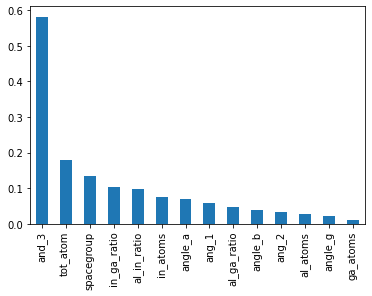

In [86]:
# Visualize feature importances
rfr1_fimp = final_rfr1.named_steps['randomforestregressor'].feature_importances_
rfr2_fimp = final_rfr2.named_steps['randomforestregressor'].feature_importances_

xgbr1_fimp = final_xgbr1.named_steps['xgbregressor'].feature_importances_
xgbr2_fimp = final_xgbr2.named_steps['xgbregressor'].feature_importances_

rfr1_importances = pd.Series( rfr1_fimp , index = X1_train.columns )
rfr1_importances.sort_values( ascending = False , inplace = True )
rfr1_importances.plot( kind = 'bar' )

rfr2_importances = pd.Series( rfr2_fimp , index = X2_train.columns )
rfr2_importances.sort_values( ascending = False , inplace = True )
rfr2_importances.plot( kind = 'bar' )

xgbr1_importances = pd.Series( xgbr1_fimp , index = X1_train.columns )
xgbr1_importances.sort_values( ascending = False , inplace = True )
xgbr1_importances.plot( kind = 'bar' )

xgbr2_importances = pd.Series( xgbr2_fimp , index = X2_train.columns )
xgbr2_importances.sort_values( ascending = False , inplace = True )
xgbr2_importances.plot( kind = 'bar' )

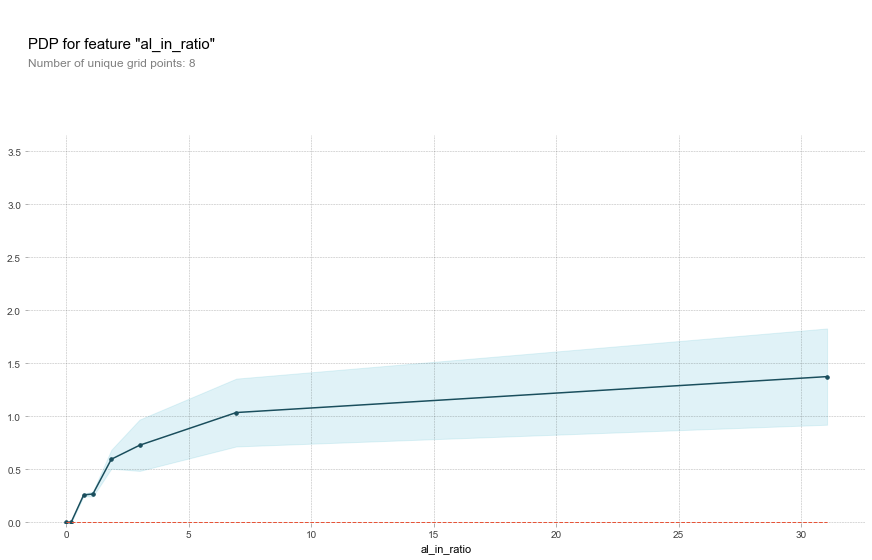

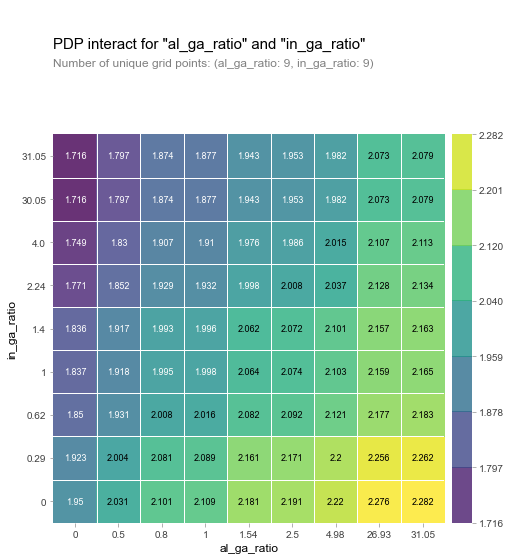

In [62]:
# Band Gap Energy - Visualization of single and double feature importances
feature = 'al_in_ratio'

isolate1 = pdp_isolate( model = rscv_xgbr1 ,
                       dataset = X1_val ,
                       model_features = X1_val.columns ,
                       feature = feature )
pdp_plot( isolate1, feature_name = feature );

features = [ 'al_ga_ratio' , 'in_ga_ratio' ]

interact1 = pdp_interact( model = rscv_xgbr1 ,
                         dataset = X1_val ,
                         model_features = X1_val.columns ,
                         features = features )
pdp_interact_plot( interact1 , plot_type = 'grid' , feature_names = features );

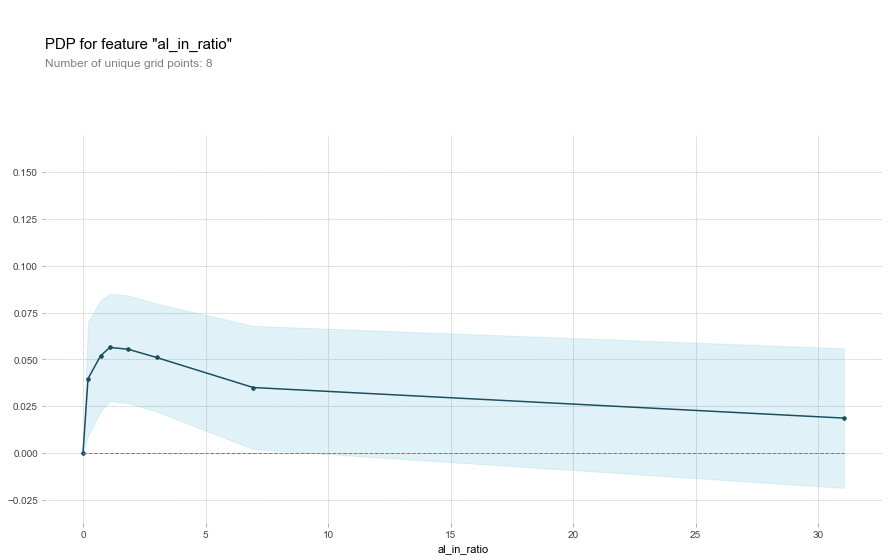

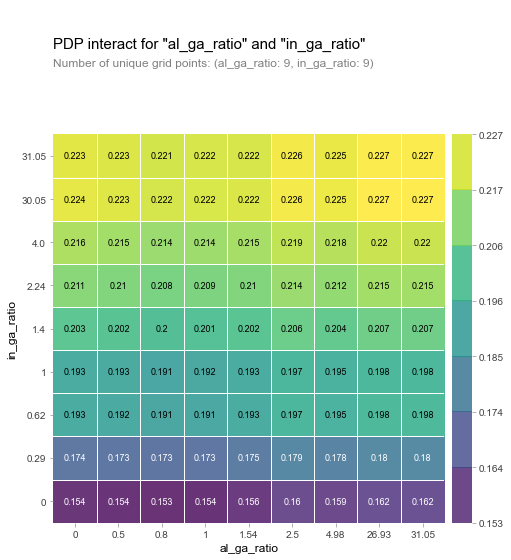

In [63]:
# Formation Energy - Visualization of single and double feature importances 
isolate2 = pdp_isolate( model = rscv_xgbr2 ,
                        dataset = X2_val ,
                        model_features = X2_val.columns ,
                        feature = feature )
pdp_plot( isolate2 , feature_name = feature );

interact2 = pdp_interact( model = rscv_xgbr2 ,
                          dataset = X2_val ,
                          model_features = X2_val.columns ,
                          features = features )
pdp_interact_plot( interact2 , plot_type = 'grid' , feature_names = features );

In [66]:
# Notes for app
# permutation importance?

# add packages needed to pipfile
# add files to notebooks folder

# open folder in visual studio 
# open virtual env in vsc terminal
# pipenv install

# run.py rununs everything 
# brand='Transparent Conductors'
# pages subfolder is where you put in your code and edit content of tabs
# add to notebook: 
# from joblib import dump
# 


AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'